# Timing analysis

In [1]:
import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
os.chdir("..")
utils_path = "utils/"
if not utils_path in sys.path:
    sys.path.insert(0, utils_path)
from helper import *

## Data loading

In [3]:
def duration_to_timedelta(duration):
    duration_comps = duration.split(":")
    if len(duration_comps) > 2:
        hours, minutes, seconds = duration_comps[-3], duration_comps[-2], duration_comps[-1]
    else:
        hours, (minutes, seconds) = (0, duration_comps)
    return pd.Timedelta(hours=float(hours), minutes=float(minutes), seconds=float(seconds))

In [4]:
def read_timing_df(src):
    return pd.read_csv(src, names=["timestamp", "run", "duration"], converters={
        "timestamp": lambda ts: pd.to_datetime(ts, unit="s"),
        "duration": duration_to_timedelta
    })

In [5]:
df_baseline = read_timing_df("ues/workloads/timing-implicit.csv")
df_baseline["workload"] = "baseline"

df_ues = read_timing_df("ues/workloads/timing-explicit.csv")
df_ues["workload"] = "ues"

df_bao = read_timing_df("pg-bao/workloads/timing-full-train.csv")
df_bao["workload"] = "bao"

df_bao_nc = read_timing_df("pg-bao/workloads/timing-full-train-no-cache.csv")
df_bao_nc["workload"] = "bao_nocache"

df_all = pd.concat([df_baseline, df_ues, df_bao, df_bao_nc]).reset_index(drop=True)
df_all["duration_s"] = df_all.duration.apply(lambda d: d.seconds)
df_all["duration_min"] = df_all.duration_s / 60

## "Evaluation"

**Careful!** The absolute values of the different workload durations can not be compared! Each workload executes differently - a BAO workload consist of three iterations over the input queries, whereas baseline/UES only iterate once over the input queries.

In [6]:
df_all.groupby("workload")["duration_s"].describe()[["mean", "std", "min", "max"]]

,mean,std,min,max
workload,,,,
bao,2377.0,132.657454,2201.0,2537.0
bao_nocache,3147.6,865.717506,2316.0,4563.0
baseline,503.2,43.848603,472.0,580.0
ues,300.4,39.468975,282.0,371.0


<AxesSubplot:xlabel='workload', ylabel='duration_min'>

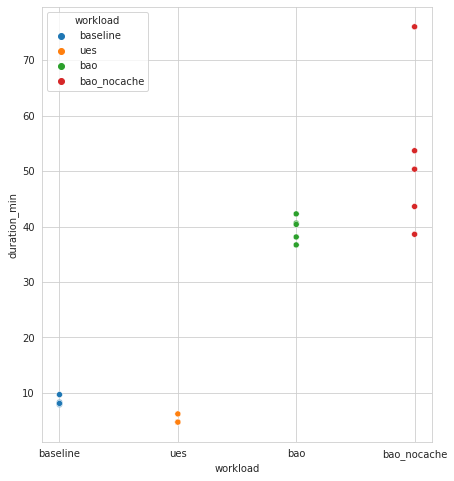

In [7]:
fig, ax = plt.subplots(figsize=(7,8))
sns.scatterplot(data=df_all, x="workload", y="duration_min", hue="workload", ax=ax)